# Outlier removal

### Support Functions

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# For make_features_labels
from tools.feature_format import featureFormat, targetFeatureSplit

# For IsolationForestTransformer
from sklearn.base import TransformerMixin

def scatter_plotter(dict_list, rows_columns=(1,1), figsize=(7, 7)):
    """
    Takes a list of dicts and plots each.
    
    dicts should contain the following:
    'array': X, y array to be plotted
    'title': title for the array
    'masks': dicts with
                -'mask': bool index to apply
                -'kwargs': keyword arguments to apply to the mask 
    """
    r = rows_columns[0]
    c = rows_columns[1]
    plt.close('all')
    fig = plt.figure(figsize=figsize, tight_layout=True)
    for i, dicty in enumerate(dict_list):
        X = dicty['array'][:,0]
        y = dicty['array'][:,1]
        ax = fig.add_subplot(r, c, i+1)
        for key, mask in dicty['masks'].items():
            idx = mask['array']
            kwargs = mask['kwargs']
            ax.scatter(X[idx],
                       y[idx], 
                       **kwargs)
        
        title = dicty.get('title', '')
        ax.set_title(title)
        ax.legend()
    plt.show()

def make_features_labels(dataset, feature_names, remove_nan=False):
    """
    Quick way to split a dataset into features and labels based on feature names
    """
    data = featureFormat(dataset, feature_names, 
                         sort_keys=True, remove_NaN=remove_nan)
    labels, features = targetFeatureSplit(data)
    labels = np.array(labels)
    features = np.array(features)
    
    return features, labels

class IsolationForestTransformer(IsolationForest, TransformerMixin):
    def __init__(self, anomaly_threshold=None, **kwargs):
        self.anomaly_threshold = anomaly_threshold
        super(IsolationForestTransformer, self).__init__(**kwargs)
          
    def get_anomaly_threshold(self):
        return self.anomaly_threshold
    
    def transform(self, X):
        scores = self.decision_function(X)
        non_outlier_mask = scores > self.get_anomaly_threshold()
        return X[non_outlier_mask]

### Get necessary data from [imputing_data](imputing_data.ipynb)

In [30]:
import pickle
with open('imputer_dict.pkl', 'rb') as f:
    imputer_dict = pickle.load(f)

### Compress data down to 2 principal components to visualize the differences between the three imputing approaches

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
dict_list = []
for key in imputer_dict.keys():
    if key != 'original':
        temp_dict = {'title': key}
        arr = pca.fit_transform(imputer_dict[key][0])
        temp_dict['array'] = arr
        labels = imputer_dict[key][1]
        temp_dict['masks'] = {}
        temp_dict['masks']['poi'] = {'array': (labels == 1),
                                     'kwargs': {'facecolors':'none', 
                                                'edgecolors':'b',
                                                'label':'poi'}}
        temp_dict['masks']['non_poi'] = {'array': (labels == 0),
                                         'kwargs': {'facecolors':'none', 
                                                    'edgecolors':'r',
                                                    's':5,
                                                    'label':'non_poi'}}
        dict_list.append(temp_dict)

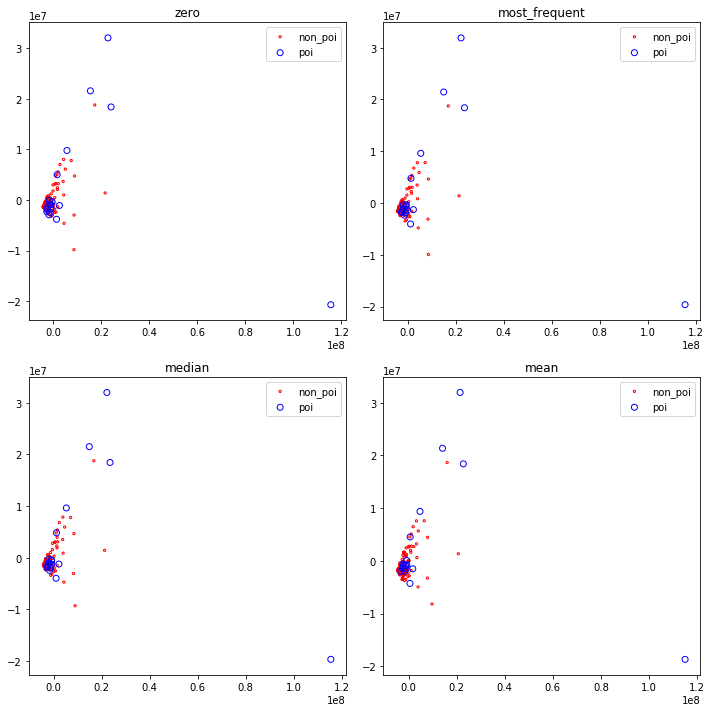

In [32]:
scatter_plotter(dict_list, rows_columns=(2,2), figsize=(10,10))

In [33]:
from sklearn.ensemble import IsolationForest
X = imputer_dict['mean'][0]
labels = imputer_dict['mean'][1]
clf = IsolationForest(contamination=0.02, random_state=42)
clf.fit(X)
scores = clf.decision_function(X)

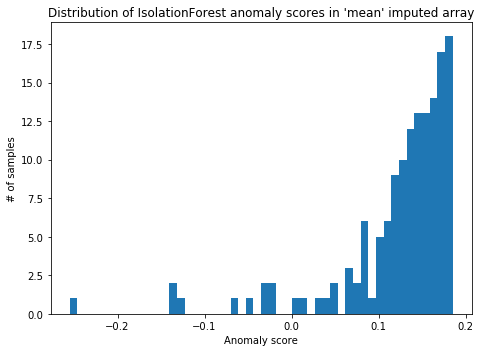

In [34]:
fig = plt.figure(figsize=(7,5), tight_layout=True)
ax = fig.gca()
ax.hist(scores, bins=50)
ax.set_title('Distribution of IsolationForest anomaly scores in \'mean\' imputed array')
ax.set_xlabel('Anomaly score')
ax.set_ylabel('# of samples')
plt.show()

In [35]:
outlier_mask = scores < -0.1
outlier_labels = labels[outlier_mask]
print 'Number of outliers: ', len(outlier_labels)
print 'Fraction of outliers that are pois: ', float(sum(outlier_labels))/len(outlier_labels)

Number of outliers:  4
Fraction of outliers that are pois:  0.5


In [36]:
clf = IsolationForestTransformer(contamination=0.02, random_state=42)
for dicty in dict_list:
    imputer_type = dicty['title']
    X = imputer_dict[imputer_type][0]
    clf.fit(X)
    scores = clf.decision_function(X)
    outlier_mask = scores < -0.1
    dicty['masks']['outliers'] = {'array': outlier_mask,
                                  'kwargs': {'color':'k',
                                             'marker':'x',
                                             's':80,
                                             'label':'outliers'}}

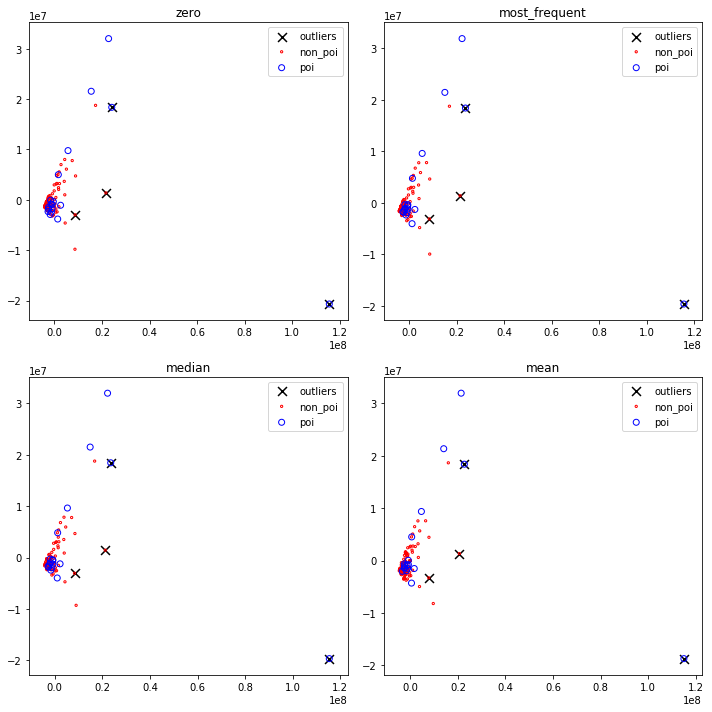

In [37]:
scatter_plotter(dict_list, rows_columns=(2,2), figsize=(10,10))

In [38]:
selected_dict_list = [dicty.copy() for dicty in dict_list]
for dicty in selected_dict_list:
    selected_mask = ~dicty['masks']['outliers']['array']
    del dicty['masks']['outliers']
    dicty['masks']['poi']['array'] = np.logical_and(selected_mask, 
                                                    dicty['masks']['poi']['array'])
    dicty['masks']['non_poi']['array'] = np.logical_and(selected_mask,
                                                        dicty['masks']['non_poi']['array'])

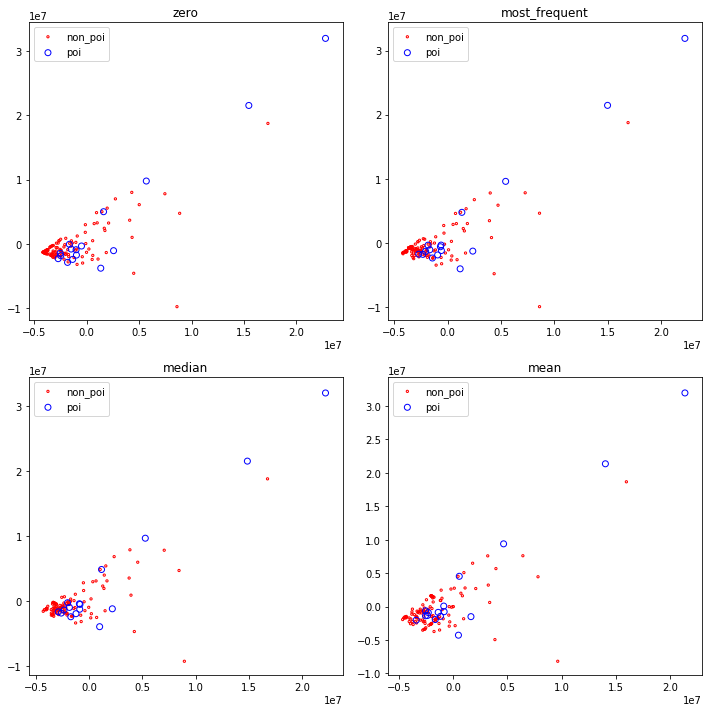

In [39]:
scatter_plotter(selected_dict_list, rows_columns=(2,2), figsize=(10,10))

In [49]:
clf = IsolationForestTransformer(anomaly_threshold=-0.1, 
                                 contamination=0.02, 
                                 random_state = 42)
X = imputer_dict['mean'][0]
X_transformed = clf.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_transformed_pca = pca.fit_transform(X_transformed)
print X_pca.shape, X_transformed_pca.shape

(145, 2) (141, 2)


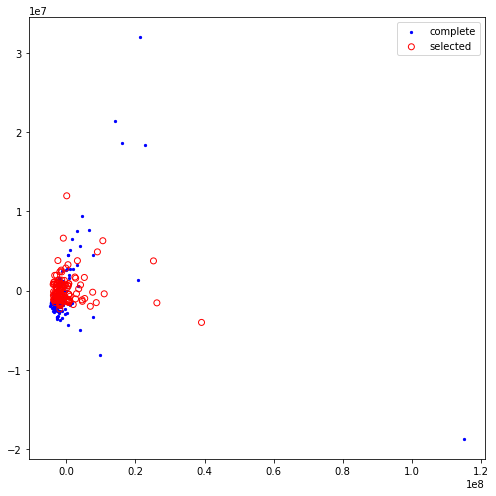

In [48]:
plt.close('all')
fig = plt.figure(figsize=(7,7), tight_layout= True)
ax = fig.gca()
ax.scatter(X_pca[:,0], X_pca[:,1], color='b', s=5, label='complete')
ax.scatter(X_transformed_pca[:,0], X_transformed_pca[:,1], 
           facecolors='none', edgecolors='r', label='selected')
ax.legend()
plt.show()